# Introduction

This work is based on the Kaggle project https://www.kaggle.com/shayanfazeli/heartbeat. The dataset in this work is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. The number of samples in both collections is large enough for training a deep neural network.

This dataset has been used in exploring heartbeat classification using deep neural network architectures, and observing some of the capabilities of transfer learning on it. The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat

# Libraries

In [1]:
#Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from ipywidgets import interact, fixed
import random
import warnings

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Deep Learning
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

Using TensorFlow backend.


# Data and EDA

First we import the data and see its dimensionality

In [44]:
mitbih_train = pd.read_csv("data/mitbih_train.csv", header=None)
mitbih_test  = pd.read_csv("data/mitbih_test.csv", header=None)

print( "Shape of the train dataset", mitbih_train.shape )
print( "Shape of the test data set", mitbih_test.shape )

Shape of the train dataset (87554, 188)
Shape of the test data set (21892, 188)


and taking a look to the data

In [45]:
mitbih_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


we can see that the columns have generic names, but the last column is the label, so we rename and discretize it

In [46]:
mitbih_train.columns = [str(i) for i in range(187)] + ["label"]
mitbih_test.columns  = [str(i) for i in range(187)] + ["label"]

mitbih_train["label"] = mitbih_train["label"].apply(int)
mitbih_test["label"]  = mitbih_test["label"].apply(int)

mitbih_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Now we can start our analysis by looking at the signals of the diferent classes of patients

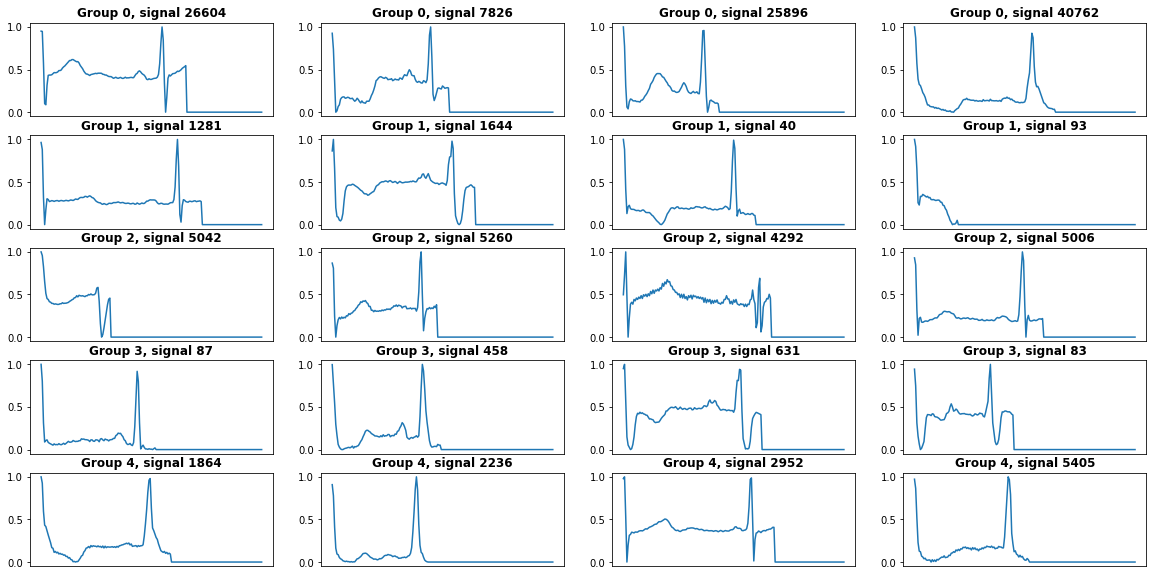

In [47]:
plt.figure(figsize = (20,10))
j = 1
for label in [0,1,2,3,4]:
    df = mitbih_train.drop("label", axis = 1)
    df_filtered = df[mitbih_train.label == label].reset_index(drop = True)
    size = 4
    signals = np.random.choice(df_filtered.index, size = size, replace = False)
    for signal in signals:
        plt.subplot(5, size, j)
        plt.plot(df.iloc[signal] ,label = "Example signal" )
        plt.title("Group {}, signal {}".format(label, signal), weight = "bold")
        plt.xticks([])
        j = j + 1
plt.show()

so we can see that a priori the signals in each class are very different between them, so we provide an interactive widget to easily select which signal is wanted to show

In [6]:
def show_plot(data, Signal):
    plt.plot(data.iloc[Signal] )
    plt.title("Group {}, signal {}".format(data.iloc[Signal,-1], Signal), weight = "bold")
    plt.xticks([])
    plt.show()

interact(lambda **kwargs: show_plot(mitbih_train, **kwargs), Signal = (0, mitbih_train.shape[0]))

interactive(children=(IntSlider(value=43777, description='Signal', max=87554), Output()), _dom_classes=('widge…

<function __main__.<lambda>(**kwargs)>

Another thing we can do is to look at the distribution of the classes

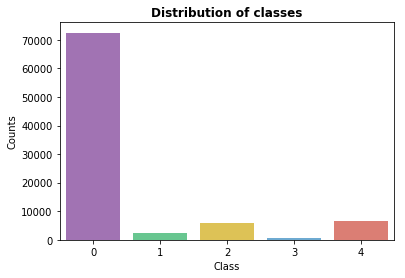

In [87]:
colors  = ["#A569BD", "#58D68D", "#F4D03F", "#5DADE2", "#EC7063"]
handles = [mpatches.Patch(color = colors[i], label = "{}".format(i)) for i in range(5)]

sns.countplot(x = "label", data = mitbih_train, palette = colors)
plt.title("Distribution of classes", weight = "bold")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

so we can see that the classes are unbalanced. This can point to an analysis the one vs. all, so, seeing this distribution

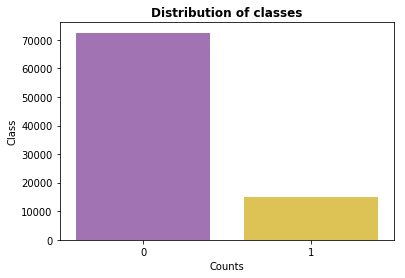

In [89]:
mitbih_train["label_ovr"] = mitbih_train.label.map({0:0, 1:1, 2:1, 3:1, 4:1})
colors2  = ["#A569BD", "#F4D03F"]
handles2 = [mpatches.Patch(color = colors[i], label = "{}".format(i)) for i in range(2)]

sns.countplot(x = "label_ovr", data = mitbih_train, palette = colors2)
plt.title("Distribution of classes", weight = "bold")
plt.xlabel("Counts")
plt.ylabel("Class")
plt.show()

we can see that the unbalancing is smaller, but still notorious.

# Dimensonality reduction

## PCA

We can start by seeing which are the most significative directions of variance on the data and seeing the percentage of variance explained by these directions. This ca be done by performing a Principal Component Analysis

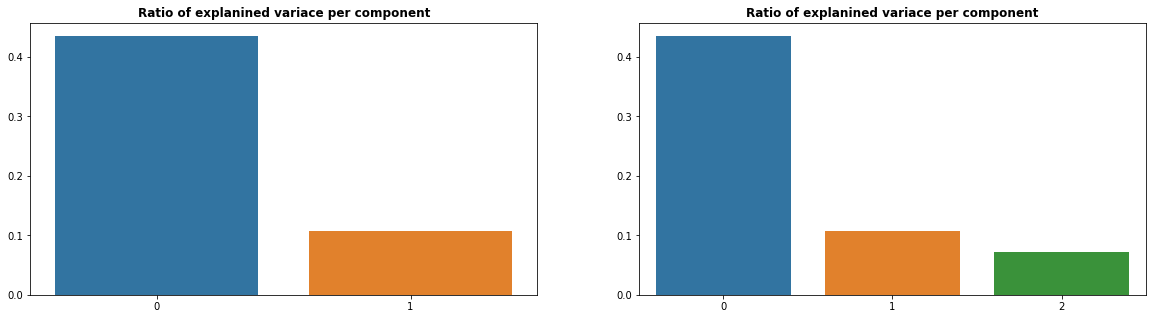

In [80]:
df_train = mitbih_train.drop(["label", "label_ovr"], axis = 1)
df_label = mitbih_train["label"]
df_label_ovr = mitbih_train["label_ovr"]

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
pca = PCA(n_components = 2)
pca.fit(df_train)
explained = pca.explained_variance_ratio_.tolist()
sns.barplot([0,1], explained)
plt.title("Ratio of explanined variace per component", weight = "bold")

plt.subplot(1,2,2)
pca = PCA(n_components = 3)
pca.fit(df_train)
explained = pca.explained_variance_ratio_.tolist()
sns.barplot([0,1,2], explained)
plt.title("Ratio of explanined variace per component", weight = "bold")
plt.show()

so we can see that the reduction is not so good, {{np.sum(explained[0:2])}} for 2 components and {{np.sum(explained[0:3])}} for 3 components, but it can still be useful to make a 2D representation of the signals

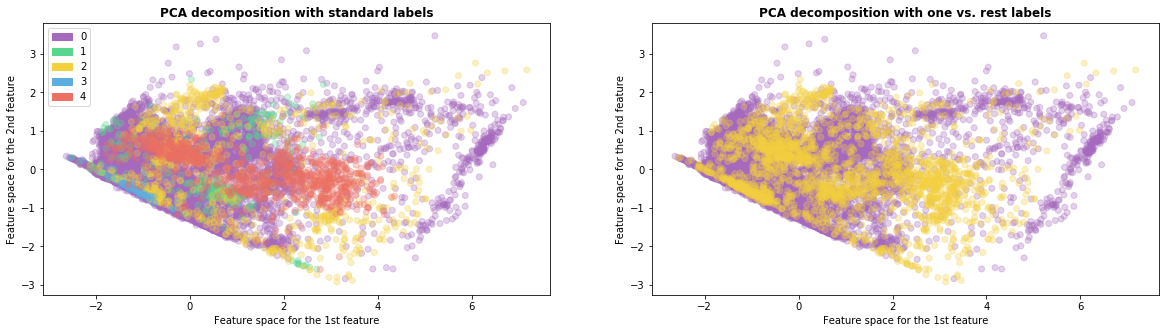

In [90]:
pca = PCA(n_components = 2)
df_train_transformed = pca.fit_transform(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label.map({i:colors[i] for i in range(5)}), 
            alpha = 0.3)
plt.title("PCA decomposition with standard labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles)
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_ovr.map({i:colors2[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("PCA decomposition with one vs. rest labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles)
plt.show()

seeing that efectively the decomposition is not useful.

## Manifold Learing

We can try now the approach of manifold learning

In [96]:
def get_proportion(data, column, prop):
    list_dataframes = list()
    for x in list(np.unique(data[column])):
        
        p=data[data[column]==x].shape[0]*prop
        a = np.arange(data[data[column]==x].shape[0])
        np.random.shuffle(a)
        
        list_dataframes.append( data[data[column]==x].iloc[a[:int(np.round(p))],:] )
        
    return pd.concat(list_dataframes)

df = get_proportion(mitbih_train, "label", 0.25)
df_train = df.drop(["label", "label_ovr"], axis = 1)
df_label = df["label"]
df_label_ovr = df["label_ovr"]

In [ ]:
isomap = Isomap(n_neighbors = 5, n_components = 2)
df_train_transformed = isomap.fit_transform(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label.map({i:colors[i] for i in range(5)}), 
            alpha = 0.3)
plt.title("Isomap mapping with standard labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles)
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_ovr.map({i:colors2[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("Isomap mapping with one vs. rest labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.legend(handles=handles)
plt.show()

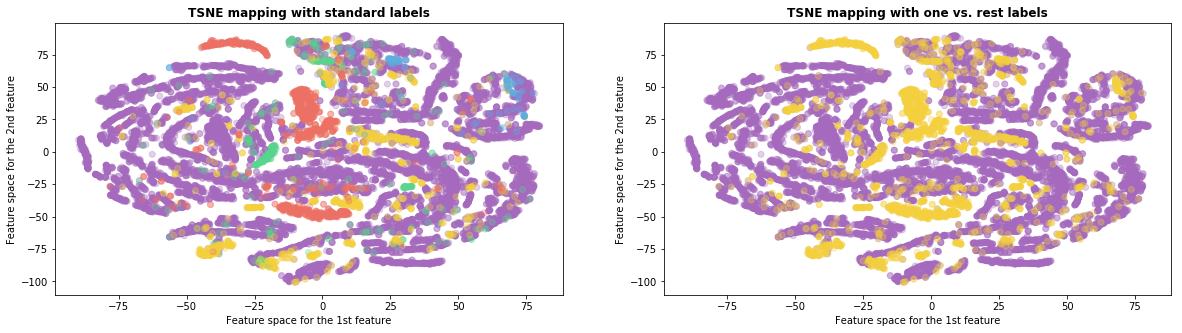

In [93]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 0)
df_train_transformed = tsne.fit_transform(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label.map({i:colors[i] for i in range(5)}), 
            alpha = 0.3)
plt.title("TSNE mapping with standard labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_ovr.map({i:colors2[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("TSNE mapping with one vs. rest labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

# Clustering

We can start this approach seeing which is the best optimal number of clusters to do, this can be done by the objective method of the elbow curve

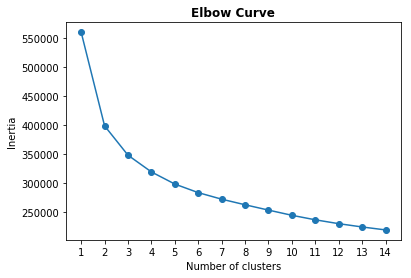

In [196]:
nclust = range(1,15)
inertias = []
for k in nclust:
    model = KMeans(n_clusters = k, n_jobs = -1, random_state = 1)
    model.fit(df_train)
    inertias.append(model.inertia_)

plt.plot(nclust, inertias, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Curve", weight = "bold")
plt.xticks(nclust)
plt.show()

so we can see that 2 is a not so bad approach, representing the one vs. all labels, but 5 seems to be the best approach, representing the actual labels.

## One vs. rest

So, doing first the approach with 2 clusters we can check the performance of the model looking at its silhouette plot

In [197]:
def make_silhouette_plot(X, cluster_labels, n_clusters):
    # Make the necessary space
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])

    # Compute silhouette scores for each sample and average
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor = colors[i], edgecolor = colors[i], alpha = 0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

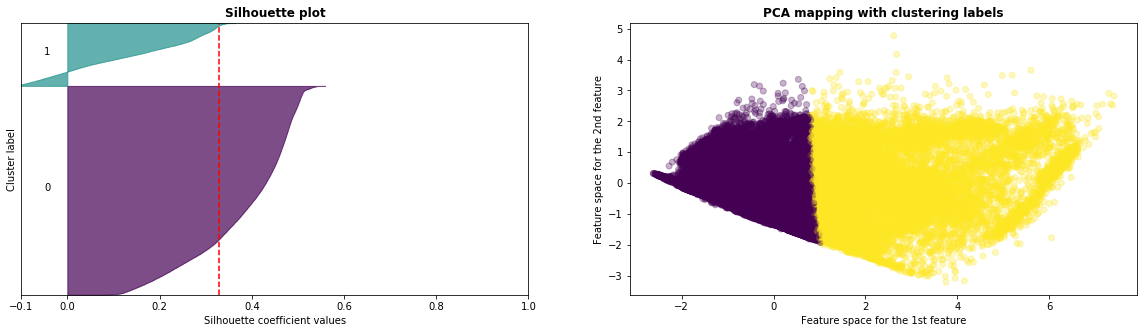

In [198]:
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
cluster_labels = kmeans.fit_predict(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
make_silhouette_plot(df_train, cluster_labels, n_clusters)
plt.title("Silhouette plot", weight = "bold")
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], y = df_train_transformed[:,1], c = cluster_labels, cmap = "viridis", alpha = 0.3)
plt.title("PCA mapping with clustering labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

We can also study the performance of the model studying the confusion matrix

In [ ]:
cm = confusion_matrix(mitbih_train.Heart, yk_pred)
sns.heatmap(cm, annot = True, fmt = 'g')
plt.show()

## Real labels

We can repeat this with the 5 clusters aproach

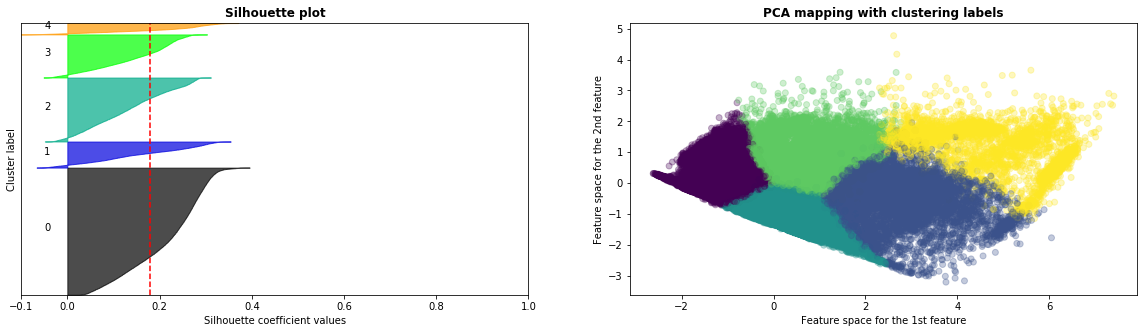

In [178]:
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
cluster_labels = kmeans.fit_predict(df_train)

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
make_silhouette_plot(df_train, cluster_labels, n_clusters)
plt.title("Silhouette plot", weight = "bold")
plt.subplot(1,2,2)
plt.scatter(x = df_train_transformed[:,0], 
            y = df_train_transformed[:,1], 
            c = df_label_ova.map({i:colors[i] for i in range(2)}), 
            alpha = 0.3)
plt.title("PCA mapping with clustering labels", weight = "bold")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

# Supervised: standard algorithms

Now we are going to try some standard classfication algorithms to have a benchmark to the complicated models that we are going to use in the next sections.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_label,
                                                    test_size = 0.3, stratify = df_label, 
                                                    random_state = 0)

In [ ]:
def make_classifier(classifier, label, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_pred, y_test)
    cm = cm.astype('float') / cm.sum(axis=1)
    
    print("Accuracy train:", classifier.score(X_train, y_train))
    print("Accuracy test: ", classifier.score(X_test, y_test))
    
    plt.figure(figsize = (20,5))
    plt.subplot(1,2,1)
    sns.heatmap(cm, annot = True, fmt = '.4f', cmap = plt.cm.Blues)
    plt.title("Confusion matrix for {}".format(label), weight = "bold")
    
    plt.subplot(1,2,2)
    sns.countplot(x = "label", data = pd.DataFrame(y_pred, columns = ["label"]))
    plt.title("Distribution of predicted classes for {}".format(label), weight = "bold")
    plt.show()
    
    print(classification_report(y_pred, y_test))

## Logistic Regression

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 5)
make_classifier(classifier, "Logistic Regression" , X_train, X_test, y_train, y_test)

Accuracy train: 0.9729143211447778


## Decision Tree

Accuracy train: 1.0
Accuracy test:  0.9586553470133627


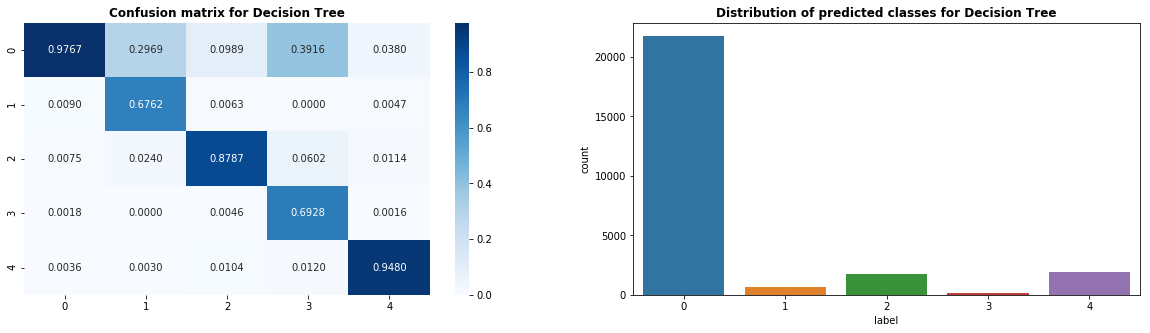

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21773
           1       0.68      0.68      0.68       667
           2       0.88      0.88      0.88      1739
           3       0.60      0.69      0.64       166
           4       0.94      0.95      0.95      1922

   micro avg       0.96      0.96      0.96     26267
   macro avg       0.82      0.83      0.82     26267
weighted avg       0.96      0.96      0.96     26267



In [232]:
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
make_classifier(classifier, "Decision Tree" , X_train, X_test, y_train, y_test)

# Supervised: ensembles

## Random forest

Accuracy train: 0.9975524988986245
Accuracy test:  0.9712567099402292


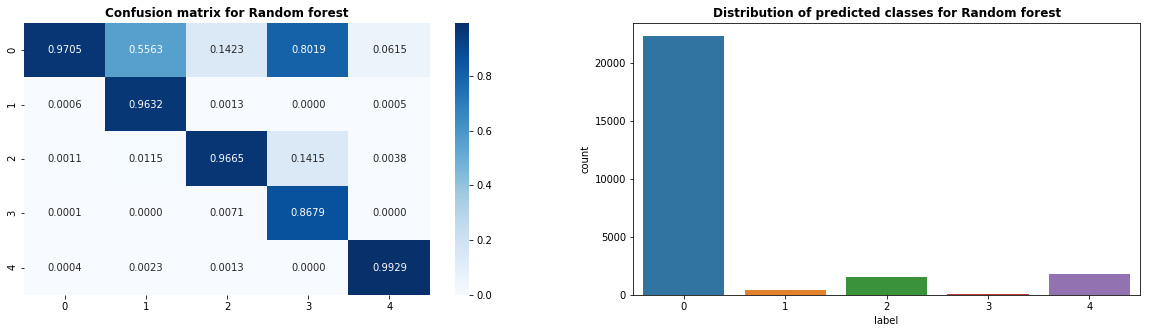

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     22351
           1       0.63      0.96      0.76       435
           2       0.86      0.97      0.91      1553
           3       0.48      0.87      0.62       106
           4       0.94      0.99      0.96      1822

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.78      0.95      0.85     26267
weighted avg       0.98      0.97      0.97     26267



In [233]:
classifier = RandomForestClassifier(n_estimators = 10, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Random forest" , X_train, X_test, y_train, y_test)

## Extra trees

Accuracy train: 1.0
Accuracy test:  0.9723226862603267


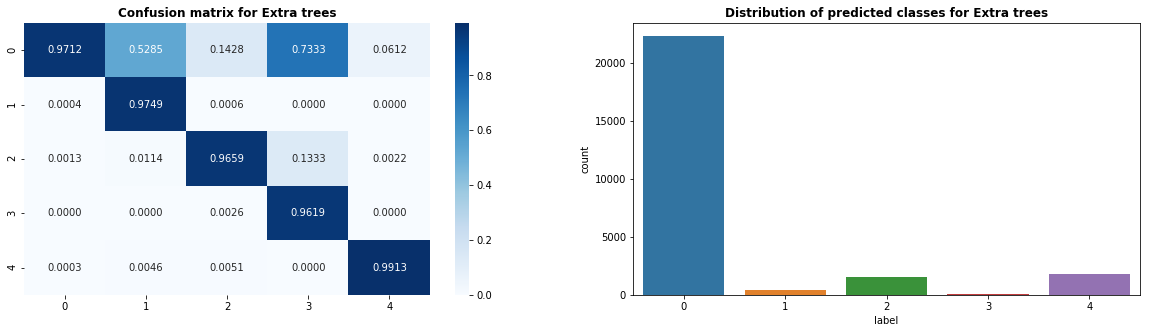

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     22339
           1       0.64      0.97      0.77       439
           2       0.86      0.97      0.91      1555
           3       0.53      0.96      0.68       105
           4       0.94      0.99      0.96      1829

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.79      0.97      0.86     26267
weighted avg       0.98      0.97      0.97     26267



In [234]:
classifier = ExtraTreesClassifier(n_estimators = 10, n_jobs = -1, random_state = 0)
make_classifier(classifier, "Extra trees" , X_train, X_test, y_train, y_test)

## XGBoost

# Supervised: deep learning

In [17]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(187,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, to_categorical(y_train), epochs=10)

print("Evaluation: ")
mse, acc = model.evaluate(X_test, y_test)
print('mean_squared_error :', mse)
print('accuracy:', acc)

Epoch 1/10
61287/61287 [==============================] - 14s 226us/step - loss: nan - acc: nan
Epoch 2/10
61287/61287 [==============================] - 12s 197us/step - loss: nan - acc: nan
Epoch 3/10
61287/61287 [==============================] - 12s 194us/step - loss: nan - acc: nan
Epoch 4/10
61287/61287 [==============================] - 12s 192us/step - loss: nan - acc: nan0s - loss: nan 
Epoch 5/10
61287/61287 [==============================] - 13s 208us/step - loss: nan - acc: nan
Epoch 6/10
61287/61287 [==============================] - 14s 224us/step - loss: nan - acc: nan
Epoch 7/10
61287/61287 [==============================] - 13s 211us/step - loss: nan - acc: nan
Epoch 8/10
61287/61287 [==============================] - 13s 206us/step - loss: nan - acc: nan
Epoch 9/10
61287/61287 [==============================] - 14s 225us/step - loss: nan - acc: nan
Epoch 10/10
61287/61287 [==============================] - 13s 218us/step - loss: nan - acc: nan
Evaluation: 


ValueError: Error when checking target: expected dense_12 to have shape (5,) but got array with shape (1,)

# Resources

https://www.kaggle.com/shayanfazeli/heartbeat

https://scikit-learn.org/stable/